In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import numpy as np
import pandas as pd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)


sys.path.insert(0, "../")
#import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="fibro", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model",
    model_name="best_model.pt",
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=15, # Default number of epochs for fine-tuning
    n_bins=51, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Currently logged in as: andrewhz-zhang. Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'fibro', 'do_train': True, 'load_model': '/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model', 'model_name': 'best_model.pt', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 15, 'n_bins': 51, 'lr': 0.0001, 'batch_size': 64, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [3]:
from pathlib import Path
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

dataset_name = config.dataset_name
save_dir = Path(f"/scratch/ssd004/scratch/ahz/perturb/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")

save to /scratch/ssd004/scratch/ahz/perturb/dev_fibro-Feb13-00-34


In [4]:
from pathlib import Path

## Load and preprocess dataset

####  ✅ Note
Perturbation datasets can be found in this path: `/scratch/ssd004/scratch/chloexq/perturb_analysis/{dataset_name}` 

In [5]:
data_dir = Path("/scratch/ssd004/scratch/chloexq/perturb_analysis")
adata = sc.read(data_dir / "norman/perturb_processed.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [7]:
adata.var.index = pd.Index(adata.var["gene_name"])

In [8]:
np.unique(adata.obs.condition.values)

array(['AHR+FEV', 'AHR+KLF1', 'AHR+ctrl', 'ARID1A+ctrl', 'ARRDC3+ctrl',
       'ATL1+ctrl', 'BAK1+ctrl', 'BCL2L11+BAK1', 'BCL2L11+TGFBR2',
       'BCL2L11+ctrl', 'BCORL1+ctrl', 'BPGM+SAMD1', 'BPGM+ZBTB1',
       'BPGM+ctrl', 'C19orf26+ctrl', 'C3orf72+FOXL2', 'C3orf72+ctrl',
       'CBFA2T3+ctrl', 'CBL+CNN1', 'CBL+PTPN12', 'CBL+PTPN9',
       'CBL+TGFBR2', 'CBL+UBASH3A', 'CBL+UBASH3B', 'CBL+ctrl',
       'CDKN1A+ctrl', 'CDKN1B+CDKN1A', 'CDKN1B+ctrl', 'CDKN1C+CDKN1A',
       'CDKN1C+CDKN1B', 'CDKN1C+ctrl', 'CEBPA+ctrl', 'CEBPB+CEBPA',
       'CEBPB+MAPK1', 'CEBPB+OSR2', 'CEBPB+PTPN12', 'CEBPB+ctrl',
       'CEBPE+CEBPA', 'CEBPE+CEBPB', 'CEBPE+CNN1', 'CEBPE+KLF1',
       'CEBPE+PTPN12', 'CEBPE+RUNX1T1', 'CEBPE+SPI1', 'CEBPE+ctrl',
       'CELF2+ctrl', 'CITED1+ctrl', 'CKS1B+ctrl', 'CLDN6+ctrl',
       'CNN1+MAPK1', 'CNN1+UBASH3A', 'CNN1+ctrl', 'CNNM4+ctrl',
       'COL1A1+ctrl', 'COL2A1+ctrl', 'CSRNP1+ctrl', 'DLX2+ctrl',
       'DUSP9+ETS2', 'DUSP9+IGDCC3', 'DUSP9+KLF1', 'DUSP9+MAPK1',
   

In [9]:
len(np.unique(adata.obs.condition.values))

284

In [10]:
single_gene_filter = [i for i in np.unique(adata.obs.condition.values) if not ('+' in i and 'ctrl' not in i)]
print(single_gene_filter, len(single_gene_filter))

['AHR+ctrl', 'ARID1A+ctrl', 'ARRDC3+ctrl', 'ATL1+ctrl', 'BAK1+ctrl', 'BCL2L11+ctrl', 'BCORL1+ctrl', 'BPGM+ctrl', 'C19orf26+ctrl', 'C3orf72+ctrl', 'CBFA2T3+ctrl', 'CBL+ctrl', 'CDKN1A+ctrl', 'CDKN1B+ctrl', 'CDKN1C+ctrl', 'CEBPA+ctrl', 'CEBPB+ctrl', 'CEBPE+ctrl', 'CELF2+ctrl', 'CITED1+ctrl', 'CKS1B+ctrl', 'CLDN6+ctrl', 'CNN1+ctrl', 'CNNM4+ctrl', 'COL1A1+ctrl', 'COL2A1+ctrl', 'CSRNP1+ctrl', 'DLX2+ctrl', 'DUSP9+ctrl', 'EGR1+ctrl', 'ELMSAN1+ctrl', 'ETS2+ctrl', 'FEV+ctrl', 'FOSB+ctrl', 'FOXA1+ctrl', 'FOXA3+ctrl', 'FOXF1+ctrl', 'FOXL2+ctrl', 'FOXO4+ctrl', 'GLB1L2+ctrl', 'HES7+ctrl', 'HK2+ctrl', 'HNF4A+ctrl', 'HOXA13+ctrl', 'HOXB9+ctrl', 'HOXC13+ctrl', 'IER5L+ctrl', 'IGDCC3+ctrl', 'IKZF3+ctrl', 'IRF1+ctrl', 'ISL2+ctrl', 'JUN+ctrl', 'KIAA1804+ctrl', 'KIF18B+ctrl', 'KIF2C+ctrl', 'KLF1+ctrl', 'KMT2A+ctrl', 'LHX1+ctrl', 'LYL1+ctrl', 'MAML2+ctrl', 'MAP2K3+ctrl', 'MAP2K6+ctrl', 'MAP4K3+ctrl', 'MAP4K5+ctrl', 'MAP7D1+ctrl', 'MAPK1+ctrl', 'MEIS1+ctrl', 'MIDN+ctrl', 'NCL+ctrl', 'NIT1+ctrl', 'OSR2+ctrl', 

In [11]:
adata = adata[adata.obs.condition.isin(single_gene_filter)].copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [13]:
# TODO: Update condition names 

In [14]:
ori_batch_col = "control"
adata.obs["celltype"] = adata.obs["condition"].astype("category")
adata.obs["str_batch"] = adata.obs["control"].astype(str)
data_is_raw = False

In [15]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / config.model_name
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    print(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

match 4547/5045 genes in vocabulary of size 60697.
Resume model from /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/best_model.pt, the model args will be overriden by the config /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/args.json.


In [16]:
gene_names_set = [i + '+ctrl' for i in adata.var.gene_name.values]
gene_names_set = gene_names_set + ['ctrl']

####  ✅ Note
This experiment is computationally expensive, so we select 1000 cells per perturbation condition.

In [17]:
# Cap all conditions to 1000 cells
sampled_df = (
    adata.obs[adata.obs['condition'].isin(gene_names_set)]
    .groupby('condition', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 1000), random_state=42))
)
adata = adata[sampled_df.index].copy()
adata.obs.groupby('condition').count()

,cell_type,dose_val,control,condition_name,celltype,str_batch
condition,,,,,,
AHR+ctrl,479,479,479,479,479,479
ARID1A+ctrl,182,182,182,182,182,182
ARRDC3+ctrl,405,405,405,405,405,405
ATL1+ctrl,305,305,305,305,305,305
BAK1+ctrl,534,534,534,534,534,534
...,...,...,...,...,...,...
ZBTB1+ctrl,315,315,315,315,315,315
ZBTB10+ctrl,145,145,145,145,145,145
ZBTB25+ctrl,343,343,343,343,343,343


In [18]:
# 5 conditions are capped, including ctrl
condition_counts = adata.obs.groupby('condition').count()
condition_counts[condition_counts == 1000].dropna()

,cell_type,dose_val,control,condition_name,celltype,str_batch
condition,,,,,,
ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


In [19]:
condition_names = set(adata.obs.condition.tolist())

In [20]:
condition_names.remove('ctrl')

In [21]:
condition_names_gene = [i.split('+')[0] for i in list(condition_names)]

In [22]:
condition_names_gene.sort()

####  ✅ Note
HVGs selection will filter out some perturbed genes. We manually add them back in the experiment.

In [23]:
# Do filtering
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    #binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    #result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...


In [24]:
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)

In [25]:
add_counter = 0
for g in condition_names_gene:
    if not adata.var.loc[adata.var[adata.var.gene_name==g].index, 'highly_variable'].values[0]:
        adata.var.loc[adata.var[adata.var.gene_name==g].index, 'highly_variable'] = True
        add_counter += 1

In [26]:
print('Manually add conditions: {}, {}'.format(add_counter, add_counter/len(condition_names_gene)))

Manually add conditions: 67, 0.6767676767676768


In [27]:
# This step for binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Binning data ...


In [28]:
adata = adata[:, adata.var["highly_variable"]].copy()
print(adata)

AnnData object with n_obs × n_vars = 33059 × 1267
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg'
    obsm: 'bin_edges'
    layers: 'counts', 'X_binned'


#### 🔵 Optional
Create another randomly shuffled list of `condition_names_gene_match` as control, if running the control experiment. 
Note that there are many ways to construct the control list, either from perturbation targets or random from all genes.

In [29]:
# Here is an example of randomly shuffle perturbation targets
import random
random.seed(42)
condition_names_gene_match = condition_names_gene.copy()
random.shuffle(condition_names_gene_match)

In [30]:
# Here is an example of using non-targets
# This is the most recent version
genes = adata.var["gene_name"].tolist()
non_targets = list(set(genes).difference(set(condition_names_gene)))
non_targets.sort()
random.seed(42)
random.shuffle(non_targets)
non_targets
condition_names_gene_match = non_targets[:len(condition_names_gene)]

In [31]:
print(condition_names_gene)

['AHR', 'ARID1A', 'ARRDC3', 'ATL1', 'BAK1', 'BCL2L11', 'BCORL1', 'BPGM', 'CBFA2T3', 'CBL', 'CDKN1A', 'CDKN1B', 'CDKN1C', 'CEBPA', 'CEBPB', 'CEBPE', 'CELF2', 'CITED1', 'CKS1B', 'CLDN6', 'CNN1', 'CNNM4', 'COL1A1', 'COL2A1', 'CSRNP1', 'DLX2', 'DUSP9', 'EGR1', 'ETS2', 'FEV', 'FOSB', 'FOXA1', 'FOXA3', 'FOXF1', 'FOXL2', 'FOXO4', 'GLB1L2', 'HES7', 'HK2', 'HNF4A', 'HOXA13', 'HOXB9', 'HOXC13', 'IER5L', 'IGDCC3', 'IKZF3', 'IRF1', 'ISL2', 'JUN', 'KIF18B', 'KIF2C', 'KLF1', 'KMT2A', 'LHX1', 'LYL1', 'MAML2', 'MAP2K3', 'MAP2K6', 'MAP4K3', 'MAP4K5', 'MAP7D1', 'MAPK1', 'MEIS1', 'MIDN', 'NCL', 'NIT1', 'OSR2', 'PLK4', 'POU3F2', 'PRDM1', 'PRTG', 'PTPN1', 'PTPN12', 'PTPN13', 'PTPN9', 'RREB1', 'RUNX1T1', 'S1PR2', 'SAMD1', 'SET', 'SGK1', 'SLC4A1', 'SLC6A9', 'SNAI1', 'SPI1', 'STIL', 'TBX2', 'TBX3', 'TGFBR2', 'TMSB4X', 'TP73', 'TSC22D1', 'UBASH3A', 'UBASH3B', 'ZBTB1', 'ZBTB10', 'ZBTB25', 'ZC3HAV1', 'ZNF318']


In [32]:
print(condition_names_gene_match)

['RASSF4', 'FUT7', 'IL22RA2', 'IP6K3', 'MANF', 'TIMP1', 'MLC1', 'ATF4', 'OR51E1', 'CTD-2623N2.5', 'OS9', 'CYSLTR2', 'ST3GAL6', 'LINC00895', 'HEATR9', 'ANXA2R', 'PMEPA1', 'RP11-46D6.1', 'PDE4DIP', 'RP11-404F10.2', 'APOBEC3D', 'MAOB', 'RP11-90K6.1', 'CD244', 'SVEP1', 'MEIS3', 'GHRL', 'RP11-212I21.4', 'IL6ST', 'ABCA1', 'SLC2A1-AS1', 'CTSO', 'RP11-306G20.1', 'TMEM154', 'PCAT5', 'RP11-443B7.2', 'PCDH9', 'TUBB3', 'SMYD3', 'TRAC', 'PARVG', 'NUTM2G', 'ERP27', 'GDF15', 'RP11-727F15.9', 'RP11-887P2.5', 'HBG2', 'RP5-1086K13.1', 'IRF2BP2', 'PDZK1IP1', 'TEX13D', 'RP11-498P14.5', 'PLAC8', 'C20orf202', 'BTG1', 'GPC1', 'REN', 'HBA2', 'ALDH3B1', 'AC002463.3', 'IL3RA', 'CABP4', 'ICOSLG', 'TXNIP', 'TNFRSF14', 'RP1-286D6.5', 'RP11-1152H14.1', 'EVI2B', 'PPP3CA', 'HBG1', 'PRSS57', 'CD48', 'RNF213', 'EPX', 'CD2', 'TMEM150C', 'FAM166B', 'PNOC', 'IL20', 'TCP11L2', 'CLEC4D', 'AC005616.2', 'SVOPL', 'RAP2C-AS1', 'OPRL1', 'ADIRF', 'PHLDA1', 'ARMCX3', 'FAM234A', 'OSBPL10', 'VWA7', 'ID2-AS1', 'ADRB2', 'ACE', 'ATP10D

## Prepare model input

In [33]:
max_len = adata.shape[1] + 1
max_len

1268

In [34]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)
adata.obs['batch_id'] = adata.obs['condition'].copy()
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
input_layer_key = "X_binned"

In [35]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## Load the pre-trained scGPT model

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=False,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

model.to(device)
wandb.watch(model)

Using simple batchnorm instead of domain specific batchnorm


[]

In [37]:
model.eval()
adata_t = adata.copy()

In [38]:
all_counts = (
    adata_t.layers[input_layer_key].A
    if issparse(adata_t.layers[input_layer_key])
    else adata_t.layers[input_layer_key]
)
celltypes_labels = adata_t.obs["celltype"].tolist()
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata_t.obs["batch_id"].tolist()
batch_ids = np.array(batch_ids)

tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

##  Get gene embeddings

In [39]:
with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
    gene_embeddings = model.encode_batch(
        all_gene_ids,
        all_values.float(),
        src_key_padding_mask=src_key_padding_mask,
        batch_size=config.batch_size,
        batch_labels=None,
        return_np=True,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 517/517 [03:57<00:00,  2.17it/s]


In [40]:
gene_embeddings.shape

(33059, 1268, 512)

In [41]:
all_gene_ids

tensor([[60695, 24904, 30607,  ..., 11394, 12288, 12289],
        [60695, 24904, 30607,  ..., 11394, 12288, 12289],
        [60695, 24904, 30607,  ..., 11394, 12288, 12289],
        ...,
        [60695, 24904, 30607,  ..., 11394, 12288, 12289],
        [60695, 24904, 30607,  ..., 11394, 12288, 12289],
        [60695, 24904, 30607,  ..., 11394, 12288, 12289]])

In [42]:
len(genes)

1267

In [43]:
gene_embeddings.shape

(33059, 1268, 512)

In [44]:
condition_ids = np.array(adata_t.obs["condition"].tolist())

#### ✅ Note
Each perturbation group has one n_gene x 512 aggreagted profile associated with it

In [45]:
dict_sum_condition = {}
for i, c in enumerate(condition_ids):
    if c in dict_sum_condition:
        dict_sum_condition[c]+=gene_embeddings[i, :, :]
    else:
        dict_sum_condition[c]=gene_embeddings[i, :, :]

In [46]:
dict_sum_condition_mean = {}
groups = adata_t.obs.groupby('condition').groups
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition[i]/len(groups[i])

In [47]:
dict_sum_condition_mean.keys()

dict_keys(['AHR+ctrl', 'ARID1A+ctrl', 'ARRDC3+ctrl', 'ATL1+ctrl', 'BAK1+ctrl', 'BCL2L11+ctrl', 'BCORL1+ctrl', 'BPGM+ctrl', 'CBFA2T3+ctrl', 'CBL+ctrl', 'CDKN1A+ctrl', 'CDKN1B+ctrl', 'CDKN1C+ctrl', 'CEBPA+ctrl', 'CEBPB+ctrl', 'CEBPE+ctrl', 'CELF2+ctrl', 'CITED1+ctrl', 'CKS1B+ctrl', 'CLDN6+ctrl', 'CNN1+ctrl', 'CNNM4+ctrl', 'COL1A1+ctrl', 'COL2A1+ctrl', 'CSRNP1+ctrl', 'DLX2+ctrl', 'DUSP9+ctrl', 'EGR1+ctrl', 'ETS2+ctrl', 'FEV+ctrl', 'FOSB+ctrl', 'FOXA1+ctrl', 'FOXA3+ctrl', 'FOXF1+ctrl', 'FOXL2+ctrl', 'FOXO4+ctrl', 'GLB1L2+ctrl', 'HES7+ctrl', 'HK2+ctrl', 'HNF4A+ctrl', 'HOXA13+ctrl', 'HOXB9+ctrl', 'HOXC13+ctrl', 'IER5L+ctrl', 'IGDCC3+ctrl', 'IKZF3+ctrl', 'IRF1+ctrl', 'ISL2+ctrl', 'JUN+ctrl', 'KIF2C+ctrl', 'KIF18B+ctrl', 'KLF1+ctrl', 'KMT2A+ctrl', 'LHX1+ctrl', 'LYL1+ctrl', 'MAML2+ctrl', 'MAP2K3+ctrl', 'MAP2K6+ctrl', 'MAP4K3+ctrl', 'MAP4K5+ctrl', 'MAP7D1+ctrl', 'MAPK1+ctrl', 'MEIS1+ctrl', 'MIDN+ctrl', 'NCL+ctrl', 'NIT1+ctrl', 'ctrl', 'OSR2+ctrl', 'PLK4+ctrl', 'POU3F2+ctrl', 'PRDM1+ctrl', 'PRTG+

In [48]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [49]:
perturb_conditions = list(dict_sum_condition_mean.keys())
len(perturb_conditions)

100

In [50]:
perturb_conditions.remove('ctrl')

In [51]:
assert 'ctrl' not in perturb_conditions

In [52]:
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import pandas as pd

#### ✅ Note
Calculate consine distance between control and each perturbation conditions

## Baseline Wilcoxon

In [53]:
adata_t.var.index

Index(['RP11-34P13.8', 'SAMD11', 'RNF223', 'TNFRSF18', 'TNFRSF4', 'ANKRD65',
       'TNFRSF14', 'TTC34', 'TP73', 'SMIM1',
       ...
       'KCNJ15', 'ETS2', 'ABCG1', 'TFF3', 'TFF1', 'UBASH3A', 'AP001046.6',
       'ICOSLG', 'ITGB2', 'ITGB2-AS1'],
      dtype='object', name='gene_name', length=1267)

In [54]:
# Wilcoxon rank
sc.tl.rank_genes_groups(adata_t, 'condition', method='wilcoxon', key_added = "wilcoxon", n_genes=max_len-1, reference='ctrl')
adata_t.uns['wilcoxon']['names']

rec.array([('TESC', 'BTG1', 'NEAT1', 'ALAS2', 'BAK1', 'BCL2L11', 'KRT18', 'HBZ', 'SH3BGRL3', 'CD99', 'CDKN1A', 'HBZ', 'RP11-717F1.1', 'LST1', 'PLD3', 'CEBPE', 'CEBPA', 'NEAT1', 'MFGE8', 'CLDN6', 'CNN1', 'HBZ', 'COL1A1', 'COL2A1', 'GAL', 'RNASET2', 'DUSP9', 'HBZ', 'TMSB4X', 'FEV', 'SH3BGRL3', 'GYPB', 'LYZ', 'S100A13', 'FOXL2', 'S100A13', 'SLC44A1', 'HES7', 'HK2', 'HBZ', 'GYPB', 'HOXB9', 'NEAT1', 'HBZ', 'IGDCC3', 'HBZ', 'PSMB9', 'PNMT', 'JUN', 'KIF2C', 'KIF18B', 'HBZ', 'KMT2A', 'LHX1', 'LYL1', 'ORAI2', 'MAP2K3', 'GAL', 'HBZ', 'HBZ', 'MAP7D1', 'TMSB4X', 'GYPB', 'ID2', 'NCL', 'S100A13', 'OSR2', 'HBG2', 'POU3F2', 'HBZ', 'HBZ', 'HBZ', 'PTPN9', 'HBZ', 'PIM1', 'HBZ', 'RUNX1T1', 'HBZ', 'HBZ', 'PRKCB', 'HBG2', 'AP003068.23', 'HBZ', 'S100A13', 'AIF1', 'STIL', 'RP11-717F1.1', 'AVP', 'HBZ', 'TMSB4X', 'AVP', 'TSC22D1', 'NEAT1', 'HBZ', 'HBZ', 'GYPB', 'HBZ', 'ZC3HAV1', 'HBG2'),
           ('GYPB', 'MYL4', 'RP11-717F1.1', 'HBZ', 'LHX1', 'GYPB', 'KRT8', 'AMHR2', 'VIM', 'HBZ', 'HBG2', 'ALAS2', 'ALAS2', '

In [56]:
baseline_rank = []

for c in perturb_conditions:
    hvg_list = adata_t.uns['wilcoxon']['names'][c]
    p_val = adata_t.uns['wilcoxon']['pvals_adj'][c]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(c, np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])
    baseline_rank.append(np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])

AHR+ctrl 9
ARID1A+ctrl 121
ARRDC3+ctrl 7
ATL1+ctrl 839
BAK1+ctrl 0
BCL2L11+ctrl 0
BCORL1+ctrl 3
BPGM+ctrl 2
CBFA2T3+ctrl 10
CBL+ctrl 7
CDKN1A+ctrl 0
CDKN1B+ctrl 884
CDKN1C+ctrl 5
CEBPA+ctrl 67
CEBPB+ctrl 39
CEBPE+ctrl 0
CELF2+ctrl 749
CITED1+ctrl 1
CKS1B+ctrl 87
CLDN6+ctrl 0
CNN1+ctrl 0
CNNM4+ctrl 32
COL1A1+ctrl 0
COL2A1+ctrl 0
CSRNP1+ctrl 2
DLX2+ctrl 4
DUSP9+ctrl 0
EGR1+ctrl 37
ETS2+ctrl 6
FEV+ctrl 0
FOSB+ctrl 130
FOXA1+ctrl 14
FOXA3+ctrl 5
FOXF1+ctrl 12
FOXL2+ctrl 0
FOXO4+ctrl 1
GLB1L2+ctrl 5
HES7+ctrl 0
HK2+ctrl 0
HNF4A+ctrl 7
HOXA13+ctrl 29
HOXB9+ctrl 0
HOXC13+ctrl 13
IER5L+ctrl 9
IGDCC3+ctrl 0
IKZF3+ctrl 27
IRF1+ctrl 7
ISL2+ctrl 4
JUN+ctrl 0
KIF2C+ctrl 0
KIF18B+ctrl 0
KLF1+ctrl 3
KMT2A+ctrl 0
LHX1+ctrl 0
LYL1+ctrl 0
MAML2+ctrl 1
MAP2K3+ctrl 0
MAP2K6+ctrl 20
MAP4K3+ctrl 13
MAP4K5+ctrl 31
MAP7D1+ctrl 0
MAPK1+ctrl 11
MEIS1+ctrl 860
MIDN+ctrl 8
NCL+ctrl 0
NIT1+ctrl 83
OSR2+ctrl 0
PLK4+ctrl 692
POU3F2+ctrl 0
PRDM1+ctrl 27
PRTG+ctrl 4
PTPN1+ctrl 14
PTPN9+ctrl 0
PTPN12+ctrl 1
PTPN13+ctrl

## scGPT embedding cosine distance

In [57]:
rank_list = []

for c in perturb_conditions:
    celltype_0 = c
    celltype_1 = 'ctrl'
    gene_emb_celltype_0 = np.expand_dims(dict_sum_condition_mean[celltype_0][1:, :], 0)
    gene_emb_celltype_1 = np.expand_dims(dict_sum_condition_mean[celltype_1][1:, :], 0)
    gene_dist_dict = {}
    for i, g in tqdm(enumerate(genes)):
        gene_dist_dict[g] = cosine_distances(gene_emb_celltype_0[:, i, :], gene_emb_celltype_1[:, i, :]).mean()
    df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
    df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
    print(c, np.where(df_deg.index==c.split('+')[0])[0][0])
    rank_list.append(np.where(df_deg.index==c.split('+')[0])[0][0])

1267it [00:00, 3078.02it/s]


AHR+ctrl 2


1267it [00:00, 3132.34it/s]


ARID1A+ctrl 520


1267it [00:00, 2987.29it/s]


ARRDC3+ctrl 8


1267it [00:00, 3200.61it/s]


ATL1+ctrl 525


1267it [00:00, 3227.04it/s]


BAK1+ctrl 1


1267it [00:00, 3154.84it/s]


BCL2L11+ctrl 0


1267it [00:00, 3401.24it/s]


BCORL1+ctrl 3


1267it [00:00, 3212.48it/s]


BPGM+ctrl 6


1267it [00:00, 3109.38it/s]


CBFA2T3+ctrl 24


1267it [00:00, 3167.12it/s]


CBL+ctrl 17


1267it [00:00, 3428.95it/s]


CDKN1A+ctrl 8


1267it [00:00, 3275.17it/s]


CDKN1B+ctrl 1140


1267it [00:00, 3101.21it/s]


CDKN1C+ctrl 6


1267it [00:00, 3110.53it/s]


CEBPA+ctrl 602


1267it [00:00, 3176.71it/s]


CEBPB+ctrl 239


1267it [00:00, 2991.80it/s]


CEBPE+ctrl 0


1267it [00:00, 2889.49it/s]


CELF2+ctrl 86


1267it [00:00, 3031.58it/s]


CITED1+ctrl 2


1267it [00:00, 3169.68it/s]


CKS1B+ctrl 59


1267it [00:00, 3134.44it/s]


CLDN6+ctrl 0


1267it [00:00, 3388.89it/s]


CNN1+ctrl 2


1267it [00:00, 3246.85it/s]


CNNM4+ctrl 186


1267it [00:00, 3238.01it/s]


COL1A1+ctrl 0


1267it [00:00, 3236.79it/s]


COL2A1+ctrl 0


1267it [00:00, 3378.03it/s]


CSRNP1+ctrl 1


1267it [00:00, 3256.43it/s]


DLX2+ctrl 10


1267it [00:00, 3155.47it/s]


DUSP9+ctrl 1


1267it [00:00, 3257.81it/s]


EGR1+ctrl 121


1267it [00:00, 3113.56it/s]


ETS2+ctrl 5


1267it [00:00, 3182.02it/s]


FEV+ctrl 0


1267it [00:00, 3167.22it/s]


FOSB+ctrl 780


1267it [00:00, 3237.79it/s]


FOXA1+ctrl 2


1267it [00:00, 3356.69it/s]


FOXA3+ctrl 3


1267it [00:00, 3019.67it/s]


FOXF1+ctrl 7


1267it [00:00, 3318.95it/s]


FOXL2+ctrl 2


1267it [00:00, 3214.66it/s]


FOXO4+ctrl 9


1267it [00:00, 3286.80it/s]


GLB1L2+ctrl 5


1267it [00:00, 3174.56it/s]


HES7+ctrl 0


1267it [00:00, 3296.97it/s]


HK2+ctrl 0


1267it [00:00, 3148.05it/s]


HNF4A+ctrl 2


1267it [00:00, 2929.47it/s]


HOXA13+ctrl 11


1267it [00:00, 3038.36it/s]


HOXB9+ctrl 0


1267it [00:00, 3232.82it/s]


HOXC13+ctrl 7


1267it [00:00, 3055.08it/s]


IER5L+ctrl 17


1267it [00:00, 3268.56it/s]


IGDCC3+ctrl 1


1267it [00:00, 3198.76it/s]


IKZF3+ctrl 86


1267it [00:00, 3142.37it/s]


IRF1+ctrl 13


1267it [00:00, 3157.20it/s]


ISL2+ctrl 2


1267it [00:00, 3117.19it/s]


JUN+ctrl 7


1267it [00:00, 3246.31it/s]


KIF2C+ctrl 0


1267it [00:00, 2833.32it/s]


KIF18B+ctrl 16


1267it [00:00, 3197.60it/s]


KLF1+ctrl 1


1267it [00:00, 2975.04it/s]


KMT2A+ctrl 0


1267it [00:00, 3115.01it/s]


LHX1+ctrl 0


1267it [00:00, 3118.79it/s]


LYL1+ctrl 0


1267it [00:00, 3148.53it/s]


MAML2+ctrl 1


1267it [00:00, 3225.68it/s]


MAP2K3+ctrl 0


1267it [00:00, 3131.38it/s]


MAP2K6+ctrl 8


1267it [00:00, 2825.83it/s]


MAP4K3+ctrl 16


1267it [00:00, 3081.06it/s]


MAP4K5+ctrl 17


1267it [00:00, 3225.68it/s]


MAP7D1+ctrl 0


1267it [00:00, 3147.05it/s]


MAPK1+ctrl 5


1267it [00:00, 2859.62it/s]


MEIS1+ctrl 46


1267it [00:00, 3134.09it/s]


MIDN+ctrl 16


1267it [00:00, 3039.01it/s]


NCL+ctrl 0


1267it [00:00, 3054.67it/s]


NIT1+ctrl 988


1267it [00:00, 3120.26it/s]


OSR2+ctrl 4


1267it [00:00, 3172.15it/s]


PLK4+ctrl 230


1267it [00:00, 3356.88it/s]


POU3F2+ctrl 0


1267it [00:00, 3246.27it/s]


PRDM1+ctrl 13


1267it [00:00, 3261.75it/s]


PRTG+ctrl 7


1267it [00:00, 3148.11it/s]


PTPN1+ctrl 17


1267it [00:00, 3342.01it/s]


PTPN9+ctrl 5


1267it [00:00, 3097.29it/s]


PTPN12+ctrl 5


1267it [00:00, 2990.66it/s]


PTPN13+ctrl 9


1267it [00:00, 3361.38it/s]


RREB1+ctrl 144


1267it [00:00, 3145.70it/s]


RUNX1T1+ctrl 0


1267it [00:00, 2997.03it/s]


S1PR2+ctrl 256


1267it [00:00, 3252.29it/s]


SAMD1+ctrl 6


1267it [00:00, 3223.13it/s]


SET+ctrl 33


1267it [00:00, 3288.01it/s]


SGK1+ctrl 1


1267it [00:00, 2963.44it/s]


SLC4A1+ctrl 3


1267it [00:00, 3160.34it/s]


SLC6A9+ctrl 3


1267it [00:00, 3201.80it/s]


SNAI1+ctrl 54


1267it [00:00, 3269.21it/s]


SPI1+ctrl 9


1267it [00:00, 3233.26it/s]


STIL+ctrl 24


1267it [00:00, 3226.34it/s]


TBX2+ctrl 1


1267it [00:00, 3317.31it/s]


TBX3+ctrl 2


1267it [00:00, 2968.89it/s]


TGFBR2+ctrl 1


1267it [00:00, 3158.81it/s]


TMSB4X+ctrl 0


1267it [00:00, 3244.47it/s]


TP73+ctrl 78


1267it [00:00, 3320.16it/s]


TSC22D1+ctrl 0


1267it [00:00, 3176.86it/s]


UBASH3A+ctrl 0


1267it [00:00, 3060.32it/s]


UBASH3B+ctrl 2


1267it [00:00, 3215.15it/s]


ZBTB1+ctrl 413


1267it [00:00, 3076.87it/s]


ZBTB10+ctrl 297


1267it [00:00, 3185.18it/s]


ZBTB25+ctrl 223


1267it [00:00, 3208.10it/s]


ZC3HAV1+ctrl 0


1267it [00:00, 3208.20it/s]

ZNF318+ctrl 2


## Save Results & Analysis

In [62]:
df_results = df = pd.DataFrame({
    'conditions': perturb_conditions,
    'wilcoxon': baseline_rank,
    'scGPT_rank': rank_list
})

In [63]:
df_results

,conditions,wilcoxon,scGPT_rank
0,AHR+ctrl,9,2
1,ARID1A+ctrl,121,520
2,ARRDC3+ctrl,7,8
3,ATL1+ctrl,839,525
4,BAK1+ctrl,0,1
...,...,...,...
94,ZBTB1+ctrl,957,413
95,ZBTB10+ctrl,75,297
96,ZBTB25+ctrl,806,223
97,ZC3HAV1+ctrl,0,0


In [64]:
df_results.mean()

wilcoxon      71.555556
scGPT_rank    75.595960
dtype: float64

In [65]:
df_results.to_csv('/scratch/ssd004/scratch/ahz/perturb/vevo_norman_ranks_Feb13.csv')

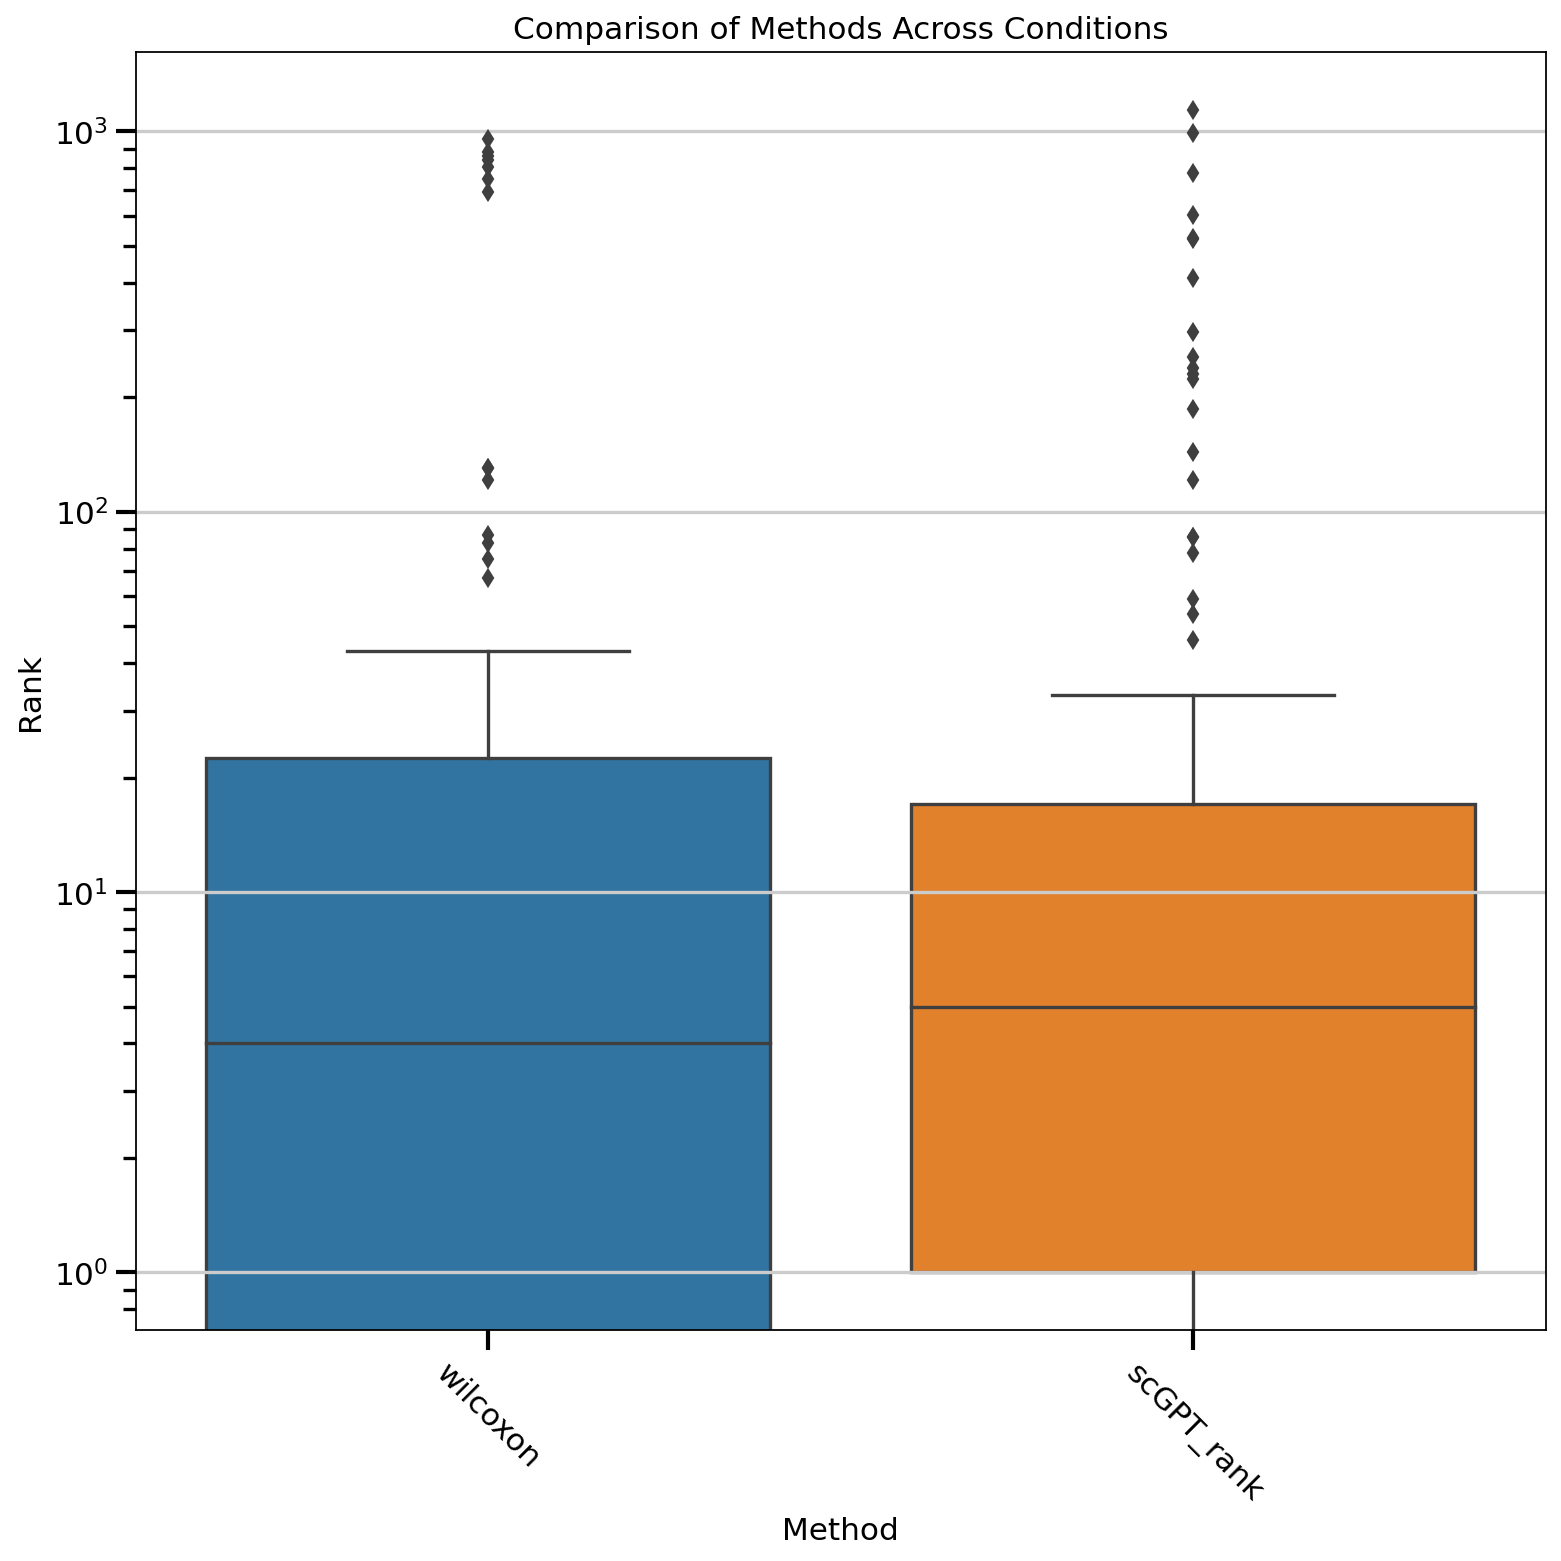

In [74]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_results)

# Add titles and labels
plt.title('Comparison of Methods Across Conditions')
plt.xlabel('Method')
plt.ylabel('Rank')
plt.xticks(rotation=-45)
plt.yscale('log')
# Display the plot
plt.tight_layout()

plt.legend([],[], frameon=False)

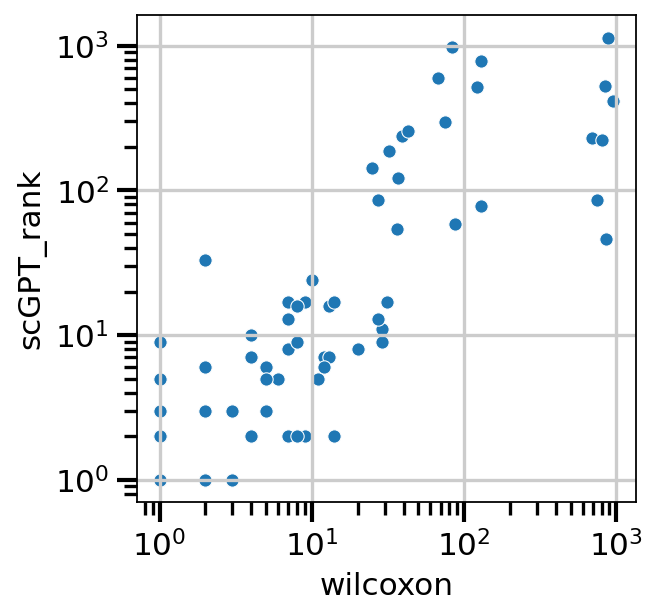

In [73]:
sns.scatterplot(data=df_results, x="wilcoxon", y="scGPT_rank")
plt.xscale('log')
plt.yscale('log')

In [76]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_results['wilcoxon'], df_results['scGPT_rank'])

print(f'Pearson Correlation: {corr}, p-value: {p_value}')

Pearson Correlation: 0.5160881847586302, p-value: 4.567253005571027e-08
